Notebook to generate figures for the paper. Specify absolute paths so that the data is easily locatable.

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from pathlib import Path
from rasterio.plot import show
import rasterio.windows as window
from shapely.geometry import Polygon
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import sys

# local imports
sys.path.insert(0, str(Path('.').absolute().parent/'lib'))
sys.path.insert(0, str(Path('.').absolute().parent))
from task_module import DeepDEMRegressionTask
# from dataset_modules import CustomInputDataset

In [2]:
# load split parameters from model
model_checkpoint = Path('/mnt/working/karthikv/DeepDEM/scripts/checkpoints/experiment_group_1/version_001/epoch=176-step=123900.ckpt')
model = DeepDEMRegressionTask.load_from_checkpoint(model_checkpoint).cuda().eval();

train_split = model.model_kwargs['train_split']
input_data_path = Path(model.model_kwargs['datapath'])

model_inferences_path = Path('/mnt/working/karthikv/DeepDEM/outputs/model_inferences/')

DeepDEMRegressionTask: *** Loading global scaling factors for WV1 Mt Baker data ***
DeepDEMRegressionTask: *** This can be overridden when initializing model (DeepDEMRegressionTask) ***


Plot of single Worldview image over study site (Mt Baker) with no data regions masked out, along with overlay show train (red shaded) and validation (blue shaded) regions for model training. Image was acquired on 09/11/2015

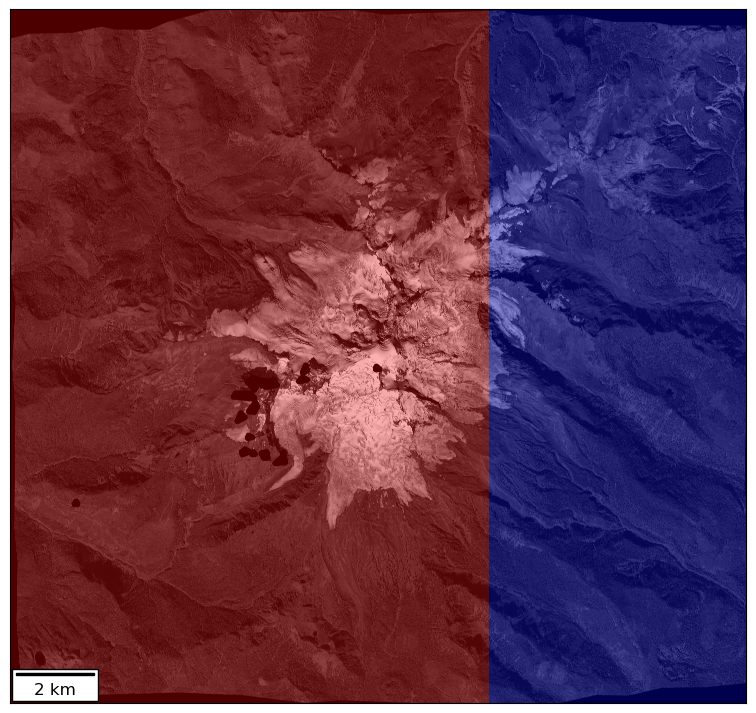

In [3]:
fig, ax = plt.subplots(1, 1, figsize = (9.5, 9.5))

with rasterio.open(input_data_path / 'final_ortho_channel1.tif') as ds:
    ortho_img = ds.read(1)
    transform=ds.transform
    bounds = ds.bounds
    crs = ds.crs

xmin, ymin, xmax, ymax = bounds
x_extent = xmax - xmin
xsplit = xmin + train_split*x_extent
train_box = Polygon.from_bounds(xmin, ymin, xsplit, ymax)
test_box = Polygon.from_bounds(xsplit, ymin, xmax, ymax)

df = gpd.GeoDataFrame({'geometry':[train_box, test_box]}, crs=crs)


show(ortho_img, ax=ax, transform=transform, cmap='gray')
df.geometry.plot(color=['red', 'blue'], ax = ax, alpha=0.3)
ax.set_xticks([])
ax.set_yticks([])

scalebar = AnchoredSizeBar(ax.transData,
                        2000 , '2 km', 'lower left', 
                        color='black',
                        frameon=True,
                        pad = 0.25,
                        sep=5,
                        fontproperties = {'weight':'normal', 'size':12},
                        size_vertical=50)

ax.add_artist(scalebar)

Ground truth hillshaded LIDAR data coincident with Worldview-1 acquisition, acquired between 08/26-09/27 2015 (See [USGS report](https://www.sciencebase.gov/catalog/item/58518b0ee4b0f99207c4f12c))

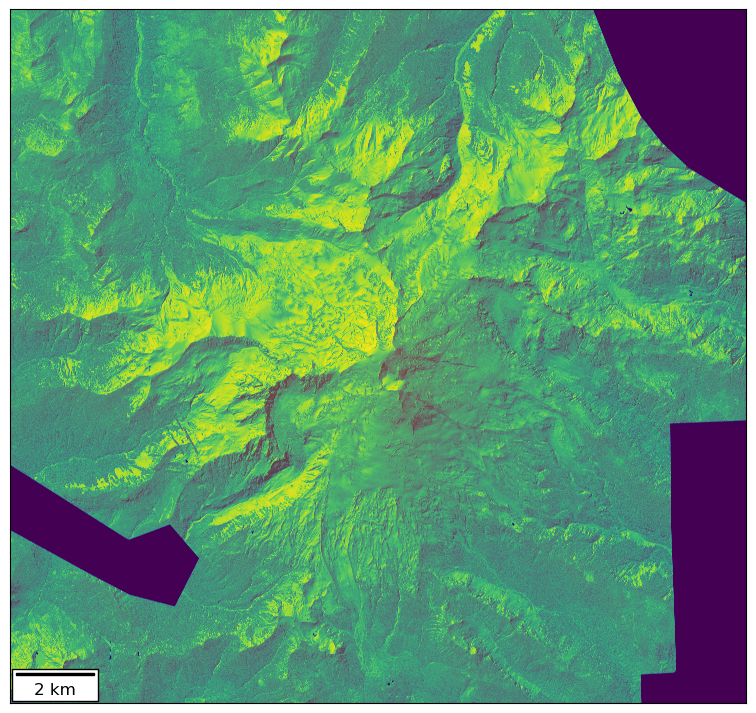

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (9.5, 9.5))

lidar_hillshade_path = Path('/mnt/working/karthikv/DeepDEM/outputs/common_files/final_lidar_data_hs.tif')

with rasterio.open(input_data_path / 'final_lidar_data.tif') as ds:
    lidar_img = ds.read(1)
    transform=ds.transform
    bounds = ds.bounds
    crs = ds.crs

with rasterio.open(lidar_hillshade_path) as ds:
    lidar_img_hs = ds.read(1)
    transform=ds.transform
    bounds = ds.bounds
    crs = ds.crs

xmin, ymin, xmax, ymax = bounds
x_extent = xmax - xmin
xsplit = xmin + train_split*x_extent
train_box = Polygon.from_bounds(xmin, ymin, xsplit, ymax)
test_box = Polygon.from_bounds(xsplit, ymin, xmax, ymax)

df = gpd.GeoDataFrame({'geometry':[train_box, test_box]}, crs=crs)


show(lidar_img_hs, ax=ax, transform=transform)
show(lidar_img, ax=ax, transform=transform, alpha=0.3)
# df.geometry.plot(color=['red', 'blue'], ax = ax, alpha=0.2)
ax.set_xticks([])
ax.set_yticks([])


scalebar = AnchoredSizeBar(ax.transData,
                        2000 , '2 km', 'lower left', 
                        color='black',
                        frameon=True,
                        pad = 0.25,
                        sep=5,
                        fontproperties = {'weight':'normal', 'size':12},
                        size_vertical=50)

ax.add_artist(scalebar)


Calculate some simple statistics using NDVI over the training and validation areas

In [5]:
with rasterio.open(input_data_path / "final_lidar_data.tif") as ds:
    lidar_img = ds.read(1)
    transform = ds.transform

with rasterio.open(input_data_path / "final_asp_dsm.tif") as ds:
    asp_dsm = ds.read(1)

with rasterio.open(input_data_path / "final_ndvi.tif") as ds:
    ndvi_img = ds.read(1)

with rasterio.open(input_data_path / "final_nodata_mask.tif") as ds:
    nodata_img = ds.read(1)

with rasterio.open(input_data_path / "final_ortho_channel1.tif") as ds:
    ortho_channel1_img = ds.read(1)

In [6]:
training_data = ndvi_img[:, 0:np.round(train_split*ndvi_img.shape[-1]).astype(int)].flatten()
validation_data = ndvi_img[:, np.round(train_split*ndvi_img.shape[-1]).astype(int):].flatten()

class1_train = 100*np.sum(training_data <=0)/training_data.size 
class2_train = 100*np.sum((training_data>0) & (training_data<0.5))/training_data.size 
class3_train = 100*np.sum(training_data >=0.5)/training_data.size 

class1_val = 100*np.sum(validation_data <=0)/validation_data.size 
class2_val = 100*np.sum((validation_data>0) & (validation_data<0.5))/validation_data.size 
class3_val = 100*np.sum(validation_data >=0.5)/validation_data.size 

print(f"NDVI <= 0 -- in training: {class1_train:.2f}% , in validation: {class1_val:.2f}%")
print(f"NDVI 0-0.5 -- in training: {class2_train:.2f}% , in validation: {class2_val:.2f}%")
print(f"NDVI >= 0.5 -- in training: {class3_train:.2f}%, in validation: {class3_val:.2f}%")

NDVI <= 0 -- in training: 19.21% , in validation: 6.16%
NDVI 0-0.5 -- in training: 13.27% , in validation: 18.78%
NDVI >= 0.5 -- in training: 67.52%, in validation: 75.06%


We can see from these calculations that there is some variation in the distribution of snow/ice, bare earth, and vegetation between the two regions. We therefore do not expect the training and validation loss to be exactly the same.

Let's plot ASP DSM/LIDAR DSM offsets over snow, which exist due to the temporal difference between the acquisition of the two datasets. Non-ice areas are masked out using an NDVI based threshold, which in turn is calculated from coarse (30 m) HLS imagery

In [7]:
residuals = (asp_dsm - lidar_img)*nodata_img
residuals = np.where(ndvi_img<=0, residuals, 0)

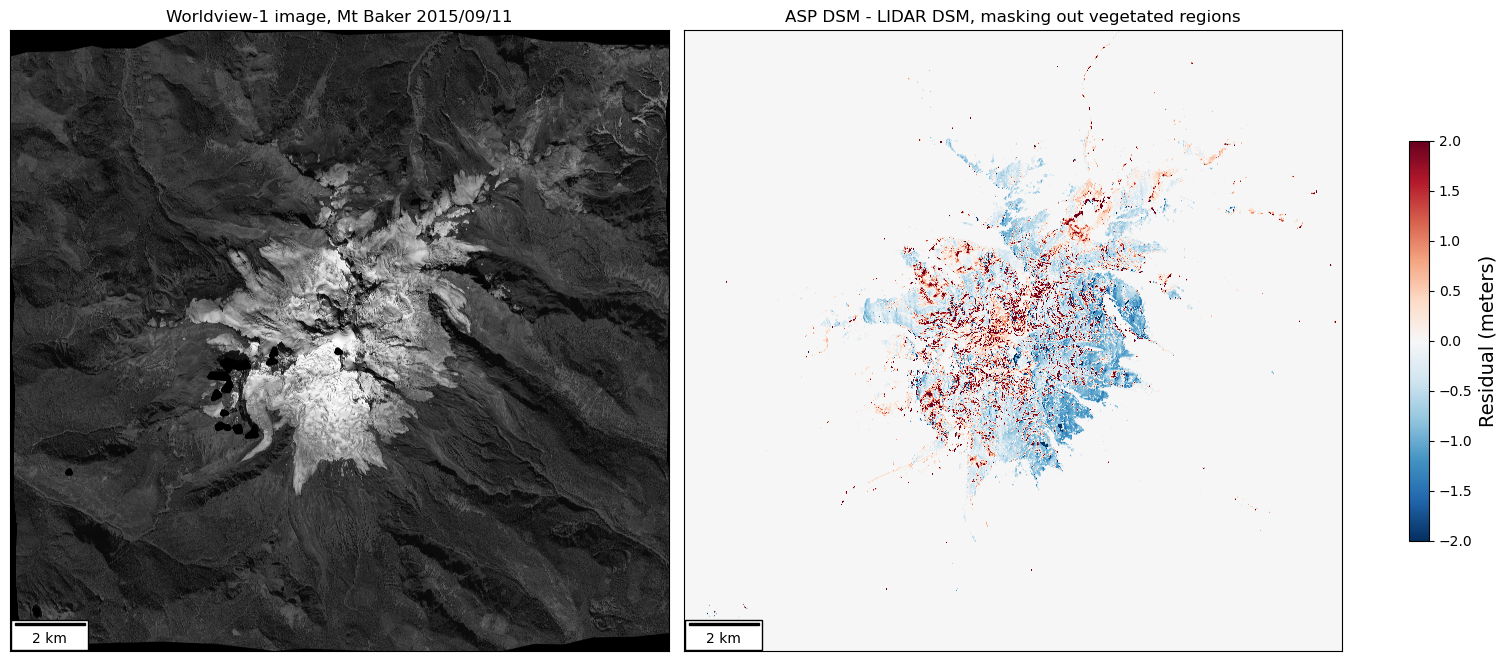

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (15, 10), constrained_layout=True)

# Ortho image
show(residuals, transform=transform, ax=ax[1])

im  = ax[0].imshow(ortho_channel1_img, cmap='gray')
ax[0].set_title('Worldview-1 image, Mt Baker 2015/09/11')
ax[0].set_xticks([])
ax[0].set_yticks([])
scalebar = AnchoredSizeBar(ax[0].transData,
                        2000 , '2 km', 'lower left', 
                        color='black',
                        frameon=True,
                        pad = 0.25,
                        sep=5,
                        fontproperties = {'weight':'normal', 'size':10},
                        size_vertical=50)

ax[0].add_artist(scalebar)


# Residuals
show(residuals, transform=transform, ax=ax[1])

im  = ax[1].imshow(residuals, vmin=-2, vmax=2, cmap='RdBu_r', interpolation=None)
cbar = plt.colorbar(im, ax=ax, fraction = 0.015)
cbar.set_label('Residual (meters)', size=14)
ax[1].set_title('ASP DSM - LIDAR DSM, masking out vegetated regions')
ax[1].set_xticks([])
ax[1].set_yticks([])
scalebar = AnchoredSizeBar(ax[1].transData,
                        2000 , '2 km', 'lower left', 
                        color='black',
                        frameon=True,
                        pad = 0.25,
                        sep=5,
                        fontproperties = {'weight':'normal', 'size':10},
                        size_vertical=50)

ax[1].add_artist(scalebar)

Plot of DeepDEM in action over vegetation

In [9]:
original_raster_path = Path('/mnt/working/karthikv/DeepDEM/data/mt_baker/WV01_20150911_1020010042D39D00_1020010043455300/original_rasters')
dtm_raster_path = Path('/mnt/working/karthikv/DeepDEM/data/mt_baker/WV01_20150911_1020010042D39D00_1020010043455300/processed_rasters_dtm')
output_data_path = Path('/mnt/working/karthikv/DeepDEM/outputs/model_inferences')

model_inference_path = 'experiment_group_1_version_001.tif'
model_dtm_inference_path = 'experiment_group_6_version_001.tif'
lidar_data_path = 'final_lidar_data.tif'
lidar_dtm_data_path = 'final_lidar_dtm_data.tif'
asp_dsm_path = 'final_asp_dsm.tif'
asp_hole_unfilled_path = '20150911_2050_1020010042D39D00_1020010043455300_1.0m-DEM_trans_dx+2.40m_dy+1.51m_dz-0.36m.tif'
nodata_mask_path = 'final_nodata_mask.tif'

In [10]:
xmin, ymax = 593964.5, 5405328.7
# xmin, ymax = 592472.4, 5400858.9
# xmin, ymax = 590242.9, 5397910.4

xmax = xmin + 512
ymin = ymax - 512
geometry = Polygon.from_bounds(xmin, ymin, xmax, ymax)

with rasterio.open(input_data_path / "final_ortho_channel1.tif") as ds:
    ortho_channel1_img = ds.read(1, window=window.from_bounds(*geometry.bounds, transform=ds.transform))

with rasterio.open(input_data_path / nodata_mask_path) as ds:
    nodata_img = ds.read(1, window=window.from_bounds(*geometry.bounds, transform=ds.transform))

# Let's read the unfilled ASP DSM for the geometry window first
with rasterio.open(original_raster_path / asp_hole_unfilled_path) as ds:
    asp_dsm_img = ds.read(1, window=window.from_bounds(*geometry.bounds, transform=ds.transform))
    nodata_img = np.where(asp_dsm_img <= 0, 0, nodata_img)

# Let's read the model inference
with rasterio.open(output_data_path / model_inference_path) as ds:
    model_inference_img = ds.read(1, window=window.from_bounds(*geometry.bounds, transform=ds.transform))
    nodata_img = np.where(model_inference_img==ds.profile['nodata'], 0, nodata_img)

with rasterio.open(output_data_path / model_dtm_inference_path) as ds:
    model_dtm_inference_img = ds.read(1, window=window.from_bounds(*geometry.bounds, transform=ds.transform))
    nodata_img = np.where(model_dtm_inference_img==ds.profile['nodata'], 0, nodata_img)

# Let's read the LIDAR data
with rasterio.open(input_data_path / lidar_data_path) as ds:
    lidar_dsm_img = ds.read(1, window=window.from_bounds(*geometry.bounds, transform=ds.transform))
    nodata_img = np.where(lidar_dsm_img==ds.profile['nodata'], 0, nodata_img)

with rasterio.open(dtm_raster_path / lidar_dtm_data_path) as ds:
    lidar_dtm_img = ds.read(1, window=window.from_bounds(*geometry.bounds, transform=ds.transform))
    nodata_img = np.where(lidar_dtm_img==ds.profile['nodata'], 0, nodata_img)

lidar_dsm_img = np.ma.masked_where(nodata_img==0, lidar_dsm_img)
lidar_dtm_img = np.ma.masked_where(nodata_img==0, lidar_dtm_img)
asp_dsm_img = np.ma.masked_where(nodata_img==0, asp_dsm_img)
model_inference_img = np.ma.masked_where(nodata_img==0, model_inference_img)
model_dtm_inference_img = np.ma.masked_where(nodata_img==0, model_dtm_inference_img)


In [11]:
original_residuals = (asp_dsm_img - lidar_dsm_img)
refined_residuals = (model_inference_img - lidar_dsm_img)

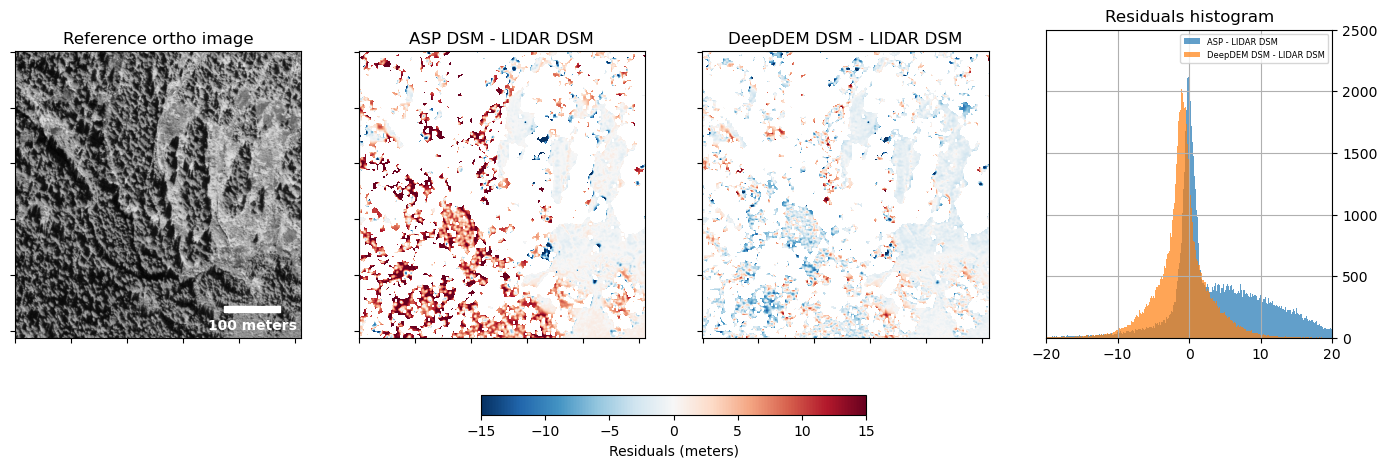

In [12]:
fig, ax = plt.subplots(1, 4, figsize = (17, 5))

vmin, vmax = -15, 15

show(ortho_channel1_img, ax=ax[0], )
ax[0].imshow(ortho_channel1_img, cmap='gray')
ax[0].set_title('Reference ortho image')
ax[1].imshow(asp_dsm_img - lidar_dsm_img, vmin=vmin, vmax=vmax, cmap='RdBu_r')
ax[1].set_title('ASP DSM - LIDAR DSM')
im = ax[2].imshow(model_inference_img - lidar_dsm_img, vmin=vmin, vmax=vmax, cmap='RdBu_r')
ax[2].set_title('DeepDEM DSM - LIDAR DSM')

ax[3].hist(original_residuals.flatten(), alpha=0.7, bins=1000, label='ASP - LIDAR DSM')
ax[3].hist(refined_residuals.flatten(), alpha=0.7, bins=1000, label='DeepDEM DSM - LIDAR DSM')

ax[3].set_xlim([-20, 20])
ax[3].set_ylim([0, 2500])
ax[3].yaxis.tick_right()
ax[3].grid()
ax[3].set_title('Residuals histogram')
plt.legend(loc='upper right', fontsize=6)

scalebar = AnchoredSizeBar(ax[0].transData,
                        100 , '100 meters', 'lower right', 
                        color='white',
                        frameon=False,
                        pad = 0.25,
                        sep=5,
                        fontproperties = {'weight':'semibold', 'size':10},
                        size_vertical=10)

ax[0].add_artist(scalebar)

# Turn off tickmarks for images
for ax_ in [ax[0], ax[1], ax[2]]:
    ax_.set_xticklabels('')
    ax_.set_yticklabels('')

cbar = plt.colorbar(im, ax=ax, fraction = 0.05, orientation='horizontal')
cbar.set_label('Residuals (meters)')

Plot histogram of residuals for the DeepDEM DTM outputs, compared to LIDAR ground returns and ASP DSM

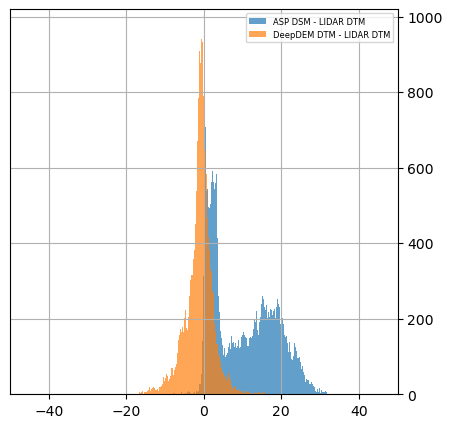

In [13]:
original_residuals = (asp_dsm_img - lidar_dtm_img)
refined_residuals = (model_dtm_inference_img - lidar_dtm_img)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.hist(original_residuals.flatten(), alpha=0.7, bins=1000, label='ASP DSM - LIDAR DTM')
ax.hist(refined_residuals.flatten(), alpha=0.7, bins=1000, label='DeepDEM DTM - LIDAR DTM')

ax.set_xlim([-50, 50])
ax.yaxis.tick_right()
ax.grid()
plt.legend(loc='upper right', fontsize=6)

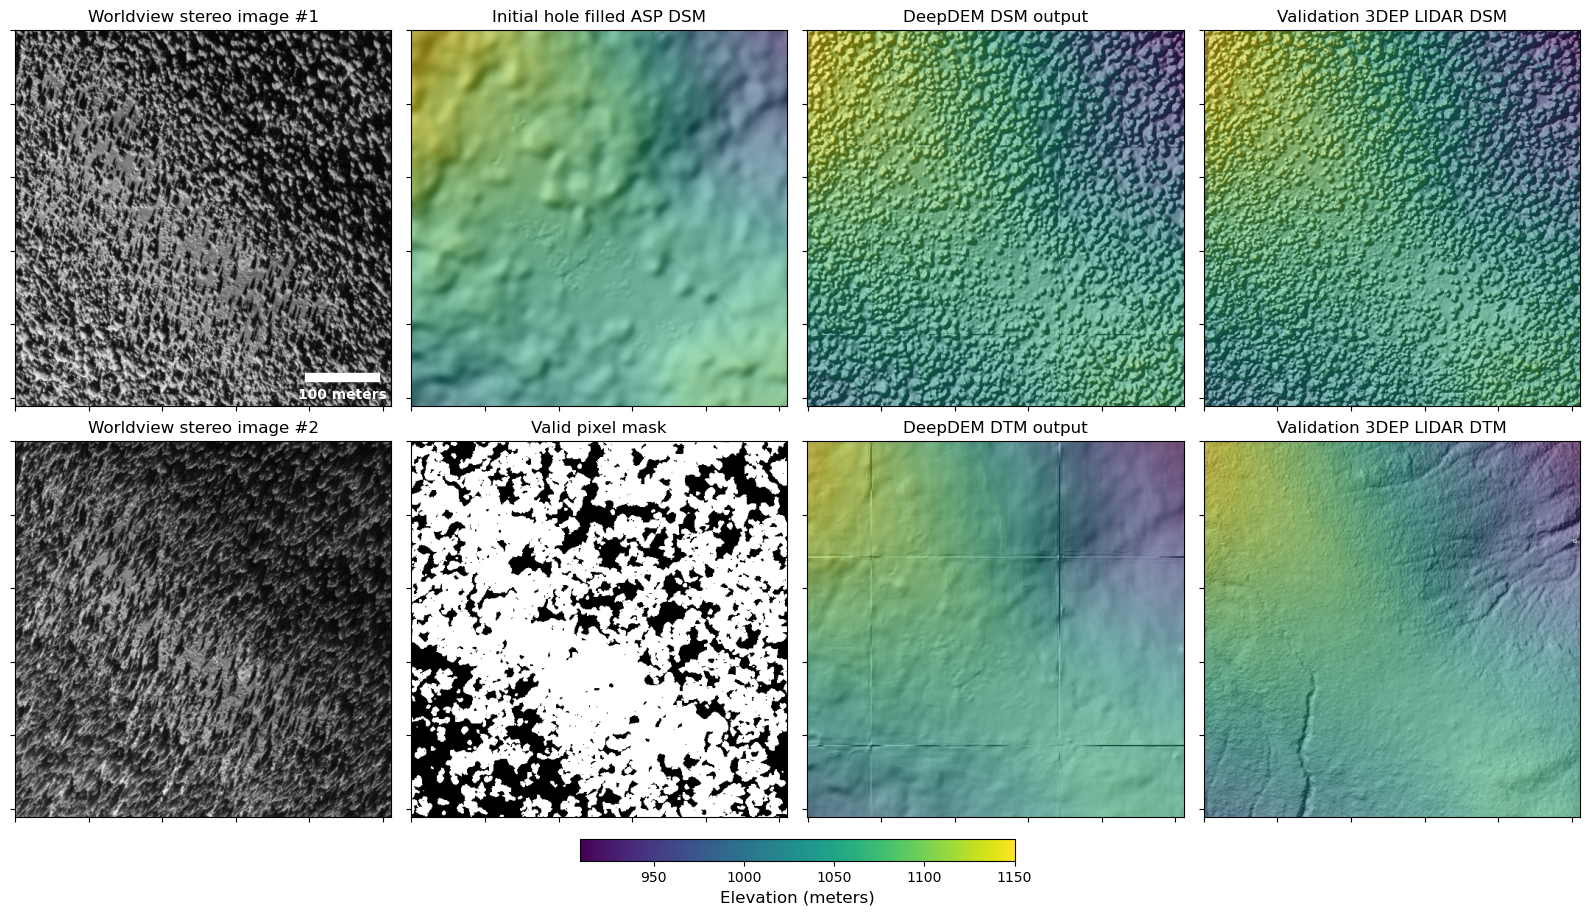

In [14]:
# Set reading window bounds below

# xmin, ymax = 593964.5, 5405328.7
xmin, ymax = 592472.4, 5400858.9
# xmin, ymax = 590242.9, 5397910.4

xmax = xmin + 512
ymin = ymax - 512
bounds = (xmin, ymin, xmax, ymax)

# 2x4 image panel that shows (column-wise):
# 1a. stereo image #1
# 1b. stereo image #2

# 2a. ASP DSM (DSM + hillshade)
# 2b. Valid Pixel mask 

# 3a. DeepDEM DSM (DSM + hillshade)
# 3b. DeepDEM DTM (DTM + hillshade)

# 4a. LIDAR DSM (DSM + hillshade)
# 4a. LIDAR DTM (DTM + hillshade)

input_raster_path_dtm = Path('/mnt/working/karthikv/DeepDEM/data/mt_baker/WV01_20150911_1020010042D39D00_1020010043455300/processed_rasters_dtm')
input_raster_path_dsm = Path('/mnt/working/karthikv/DeepDEM/data/mt_baker/WV01_20150911_1020010042D39D00_1020010043455300/processed_rasters')
model_inference_path = Path('/mnt/working/karthikv/DeepDEM/outputs/comparison_inferences')
common_files_path = Path('/mnt/working/karthikv/DeepDEM/outputs/common_files')

ortho_channel1_path = input_raster_path_dsm /  'final_ortho_channel1.tif'
ortho_channel2_path = input_raster_path_dsm /  'final_ortho_channel2.tif'
asp_dsm_path = input_raster_path_dsm / 'final_asp_dsm.tif'
asp_dsm_hs_path = common_files_path / 'final_asp_dsm_hs.tif'
nodata_mask_path = input_raster_path_dsm / 'final_nodata_mask.tif'

asp_dsm_unfilled_path = common_files_path /'final_asp_dsm_hole_unfilled.tif'

lidar_dsm_path = input_raster_path_dsm / 'final_lidar_data.tif'
lidar_dsm_hs_path = common_files_path / 'final_lidar_data_hs.tif'

lidar_dtm_path = input_raster_path_dtm / 'final_lidar_dtm_data.tif'
lidar_dtm_hs_path = common_files_path / 'final_lidar_dtm_data_hs.tif'

# DeepDEM DSM experiment results path
exp_g1_v1 = model_inference_path / 'experiment_group_1_version_001.tif'
exp_g1_v1_hs = model_inference_path /'experiment_group_1_version_001_hs.tif'

# DeepDEM DTM experiment results path
exp_g6_v1 = model_inference_path / 'experiment_group_6_version_001.tif'
exp_g6_v1_hs = model_inference_path /'experiment_group_6_version_001_hs.tif'

with rasterio.open(nodata_mask_path) as ds:
    nodata_img = ds.read(1, window=window.from_bounds(*bounds, transform=ds.transform))

with rasterio.open(ortho_channel1_path) as ds:
   ortho_ch1_img = ds.read(1, window=window.from_bounds(*bounds, transform=ds.transform))

with rasterio.open(ortho_channel2_path) as ds:
   ortho_ch2_img = ds.read(1, window=window.from_bounds(*bounds, transform=ds.transform))

with rasterio.open(asp_dsm_path) as ds:
   asp_dsm_img = ds.read(1, window=window.from_bounds(*bounds, transform=ds.transform))

with rasterio.open(asp_dsm_hs_path) as ds:
   asp_dsm_hs_img = ds.read(1, window=window.from_bounds(*bounds, transform=ds.transform))

with rasterio.open(lidar_dsm_path) as ds:
   lidar_dsm_img = ds.read(1, window=window.from_bounds(*bounds, transform=ds.transform))
   nodata_img = np.where(lidar_dsm_img == ds.profile['nodata'], 0, nodata_img)

with rasterio.open(lidar_dsm_hs_path) as ds:
   lidar_dsm_hs_img = ds.read(1, window=window.from_bounds(*bounds, transform=ds.transform))

with rasterio.open(lidar_dtm_path) as ds:
   lidar_dtm_img = ds.read(1, window=window.from_bounds(*bounds, transform=ds.transform))
   lidar_dtm_img = np.ma.masked_where(lidar_dtm_img<0, lidar_dtm_img)

with rasterio.open(lidar_dtm_hs_path) as ds:
   lidar_dtm_hs_img = ds.read(1, window=window.from_bounds(*bounds, transform=ds.transform))

with rasterio.open(exp_g6_v1) as ds:
    exp_g6v1_img = ds.read(1, window=window.from_bounds(*bounds, transform=ds.transform))

with rasterio.open(exp_g6_v1_hs) as ds:
    exp_g6v1_hs_img = ds.read(1, window=window.from_bounds(*bounds, transform=ds.transform))

with rasterio.open(exp_g1_v1) as ds:
    exp_g1v1_img = ds.read(1, window=window.from_bounds(*bounds, transform=ds.transform))

with rasterio.open(exp_g1_v1_hs) as ds:
    exp_g1v1_hs_img = ds.read(1, window=window.from_bounds(*bounds, transform=ds.transform))

fig, ax = plt.subplots(2, 4, figsize = (16, 9))

vmin, vmax = np.nanmin(lidar_dtm_img), np.nanmax(lidar_dtm_img)

ax[0][0].imshow(ortho_ch1_img, cmap='gray')
ax[0][0].set_title('Worldview stereo image #1')

ax[1][0].imshow(ortho_ch2_img, cmap='gray')
ax[1][0].set_title('Worldview stereo image #2')

ax[0][1].imshow(asp_dsm_img, vmin=vmin, vmax=vmax)
ax[0][1].imshow(asp_dsm_hs_img, alpha=0.5, cmap='gray')
ax[0][1].set_title("Initial hole filled ASP DSM")

ax[1][1].imshow(nodata_img, cmap='gray')
ax[1][1].set_title("Valid pixel mask")

ax[0][3].imshow(lidar_dsm_img, vmin=vmin, vmax=vmax)
ax[0][3].imshow(lidar_dsm_hs_img, alpha=0.5, cmap='gray')
ax[0][3].set_title("Validation 3DEP LIDAR DSM")

ax[1][3].imshow(lidar_dtm_img, vmin=vmin, vmax=vmax, aspect="auto")
ax[1][3].imshow(lidar_dtm_hs_img, alpha=0.5, cmap='gray')
ax[1][3].set_title("Validation 3DEP LIDAR DTM")

ax[0][2].imshow(exp_g1v1_img, vmin=vmin, vmax=vmax)
ax[0][2].imshow(exp_g1v1_hs_img, alpha=0.5, cmap='gray')
ax[0][2].set_title("DeepDEM DSM output")

im = ax[1][2].imshow(exp_g6v1_img, vmin=vmin, vmax=vmax)
ax[1][2].imshow(exp_g6v1_hs_img, alpha=0.5, cmap='gray')
ax[1][2].set_title("DeepDEM DTM output")

for ax_ in [ax[0][0], ax[0][1], ax[0][2], ax[0][3], ax[1][0], ax[1][1], ax[1][2], ax[1][3]]:
    ax_.set_xticklabels('')
    ax_.set_yticklabels('')

scalebar = AnchoredSizeBar(ax[0][0].transData,
                        100 , '100 meters', 'lower right', 
                        color='white',
                        frameon=False,
                        pad = 0.25,
                        sep=5,
                        fontproperties = {'weight':'semibold', 'size':10},
                        size_vertical=10)

ax[0][0].add_artist(scalebar)

plt.tight_layout()

cbar = plt.colorbar(im, ax=ax, fraction = 0.025, orientation='horizontal', pad=0.025)
cbar.set_label('Elevation (meters)', fontsize=12)


Box plot of residuals for various trained models. We mask out areas where ASP does not produce an initial DSM estimate